# NLP Code Along

For this code along we will build a spam filter! We'll use the various NLP tools we learned about as well as a new classifier, Naive Bayes.

We'll use a classic dataset for this - UCI Repository SMS Spam Detection: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

## Load Spark and Data

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('nlp').getOrCreate()

In [3]:
data = spark.read.csv("smsspamcollection/SMSSpamCollection",inferSchema=True,sep='\t')

In [4]:
# rename columns
data = data.withColumnRenamed('_c0','class').withColumnRenamed('_c1','text')

In [8]:
data.show(5)

+-----+--------------------+
|class|                text|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
+-----+--------------------+
only showing top 5 rows



## Explore data

To find additional features that might be useful for classification 

In [57]:
data.filter(data['class']=='spam').select('text').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  |
|FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv          |
|WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.|
|Had your mobile 11 months or more? U R 

### Length of the texts

+-----+-----------------+
|class|      avg(length)|
+-----+-----------------+
|  ham|71.45431945307645|
| spam|138.6706827309237|
+-----+-----------------+



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b2ec20b38>,
      dtype=object)

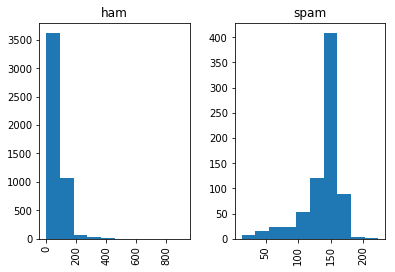

In [65]:
from pyspark.sql.functions import length

data = data\
.withColumn('length', length('text'))\

# compute average
data.groupBy('class')\
.avg().show()

# histogram
data.select(['class', 'length']).toPandas().hist(column='length', by='class')

**Length** is a useful feature!

### Proportion of capital letters

+-----+-----------------+------------------+
|class|      avg(length)|    avg(perc_caps)|
+-----+-----------------+------------------+
|  ham|71.45431945307645| 5.855368548729588|
| spam|138.6706827309237|11.091319214965829|
+-----+-----------------+------------------+



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b2eb4c9e8>,
      dtype=object)

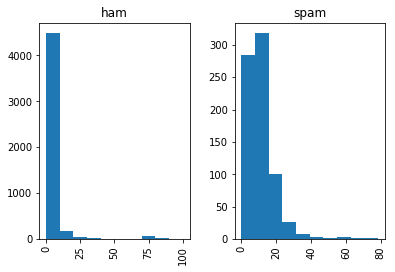

In [66]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col

perc_caps = udf(lambda s: 100*sum(1 for c in s if c.isupper())/sum(1 for c in s), DoubleType())

data = data\
.withColumn('perc_caps', perc_caps(col('text')))

# compute average
data.groupBy('class')\
.avg().show()

# histogram
data.select(['class', 'perc_caps']).toPandas().hist(column='perc_caps', by='class')

**% of caps** can be a useful feature! Maybe a little nit risky because some 'ham' messages have high % of caps, and the averages (5 vs 11) are not very separated given the range of values (0-80 aprox)

+-----+-----------------+------------------+------------------+
|class|      avg(length)|    avg(perc_caps)|  avg(perc_digits)|
+-----+-----------------+------------------+------------------+
|  ham|71.45431945307645| 5.855368548729588|0.4241214135458442|
| spam|138.6706827309237|11.091319214965829|11.653733735516644|
+-----+-----------------+------------------+------------------+



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b2eb8e4a8>,
      dtype=object)

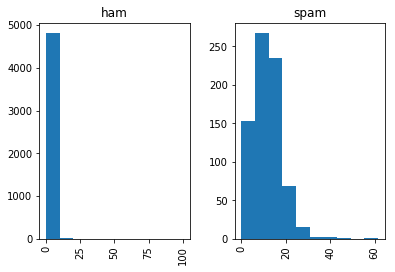

In [68]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col

perc_digits = udf(lambda s: 100*sum(1 for c in s if c.isdigit())/sum(1 for c in s), DoubleType())

data = data\
.withColumn('perc_digits', perc_digits(col('text')))

# compute average
data.groupBy('class')\
.avg().show()

# histogram
data.select(['class', 'perc_digits']).toPandas().hist(column='perc_digits', by='class')

**% of digits** can be a useful feature!

## Feature Transformations

In [69]:
data.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- perc_caps: double (nullable = true)
 |-- perc_digits: double (nullable = true)



In [84]:
# create all feature editors
from pyspark.ml.feature import Tokenizer,RegexTokenizer,StopWordsRemover, CountVectorizer,IDF,StringIndexer,VectorAssembler

# convert 'ham'/'spam' into numerical label
label_formatter = StringIndexer(inputCol='class',outputCol='label')

# break text into words
#tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# remove stop words
stop_remover = StopWordsRemover(inputCol='words',outputCol='words_cleaned')

# compute Term Frequency (TF) 
tf_computer = CountVectorizer(inputCol='words_cleaned',outputCol='tf')

# compute idf
idf_computer = IDF(inputCol="tf", outputCol="tf_idf")

In [197]:
# assemble features into vector

features = ['tf_idf','length']
#features = ['tf_idf','length', 'perc_caps', 'perc_digits']

features_assembler = VectorAssembler(inputCols=features,outputCol='features')

### Manually test the feature editors

In [110]:
#data1=label_formatter.fit(data.limit(10)).transform(data.limit(10))
#data1.select('class', 'label').show()

In [109]:
#data2=tokenizer.transform(data1)
#data2.select('text','words').show(1,truncate=False)

In [108]:
#data3=stop_remover.transform(data2)
#data3.select('words_cleaned').show(1,truncate=False)

In [107]:
#data4=tf_computer.fit(data3).transform(data3)
#data4.select('words_cleaned').show(1,truncate=False)
#data4.select('tf').show(1,truncate=False)

In [106]:
#data5=idf_computer.fit(data4).transform(data4)
#data5.select('words_cleaned').show(1,truncate=False)
#data5.select('tf_idf').show(1,truncate=False)

### Create the feature pipeline

In [198]:
from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages=[label_formatter,
                                      tokenizer,
                                      stop_remover,
                                      tf_computer,
                                      idf_computer, 
                                      features_assembler])

In [199]:
prepared_data = data_prep_pipeline.fit(data).transform(data).select(['label','features'])

In [200]:
(train_data,test_data) = prepared_data.randomSplit([0.7,0.3])

## Training Model: Naive Bayes

In [136]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes()

nb_spam_predictor = nb.fit(train_data)
test_predictions = nb_spam_predictor.transform(test_data)

#test_predictions.show(5)

## Training Model: Logistic Regression

In [190]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(regParam=0.1)

lr_spam_predictor = lr.fit(train_data)
test_predictions = lr_spam_predictor.transform(test_data)

## Training Model: Random Forest

In [201]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=100)

rf_spam_predictor = rf.fit(train_data)
test_predictions = rf_spam_predictor.transform(test_data)

## Evaluation

In [141]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

In [202]:
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
print('AUC: %f' % binary_evaluator.evaluate(test_predictions))

AUC: 0.986691


In [203]:
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy")
print("ACC: %f" % acc_evaluator.evaluate(test_predictions))

ACC: 0.863102


**Naive Bayes**
- tdidf & length: acc 95.54%
- tdidf & length & perc_caps & perc % perc_nums: acc 95.77%

**Logistic Regression (reg=0)**
- tdidf & length: acc 95.79% auc 97% 
- tdidf & length & perc_caps & perc % perc_nums: acc 96.97% auc 98%

**Logistic Regression (reg=0.1)**
- tdidf & length: acc 96.64% auc 99% 
- tdidf & length & perc_caps & perc % perc_nums: acc 97.79% auc 99%

**Logistic Regression (reg=0.01)**
- tdidf & length: acc 97.01% auc 99% 
- tdidf & length & perc_caps & perc % perc_nums: acc 97.82% auc 99%

**Random Forest (100 trees)**
- tdidf & length: acc 86.31% auc 98% 
- tdidf & length & perc_caps & perc % perc_nums: acc 86.78% auc 99%